# Building Semantic Memory with Embeddings

So far, we've mostly been treating the kernel as a stateless orchestration engine.
We send text into a model API and receive text out. 

In a previous notebook, we used `kernel arguments` to pass in additional
text into prompts to enrich them with more data. This allowed us to create a basic chat experience. 

However, if you solely relied on kernel arguments, you would quickly realize that eventually your prompt
would grow so large that you would run into the model's token limit. What we need is a way to persist state
and build both short-term and long-term memory to empower even more intelligent applications. 

To do this, we dive into the key concept of `Semantic Memory` in the Semantic Kernel. 

In [1]:
#!import config/Settings.cs

bool useAzureOpenAI = true;

In [2]:
#r "nuget: Microsoft.SemanticKernel, 1.19.0"
#r "nuget: Microsoft.SemanticKernel.Plugins.Memory, 1.19.0-alpha"
#r "nuget: System.Linq.Async, 6.0.1"

#!import config/Settings.cs

using Microsoft.SemanticKernel;
using Kernel = Microsoft.SemanticKernel.Kernel;

var builder = Kernel.CreateBuilder();

// Configure AI service credentials used by the kernel
var (useAzureOpenAI, model, azureEndpoint, apiKey, orgId) = Settings.LoadFromFile();

if (useAzureOpenAI)
    builder.AddAzureOpenAIChatCompletion(model, azureEndpoint, apiKey);
else
    builder.AddOpenAIChatCompletion(model, apiKey, orgId);

var kernel = builder.Build();

Installed Packages Microsoft.SemanticKernel, 1.19.0 Microsoft.SemanticKernel.Plugins.Memory, 1.19.0-alpha System.Linq.Async, 6.0.1

In order to use memory, we need to instantiate the Memory Plugin with a Memory Storage
and an Embedding backend. In this example, we make use of the `VolatileMemoryStore`
which can be thought of as a temporary in-memory storage (not to be confused with Semantic Memory).

This memory is not written to disk and is only available during the app session.

When developing your app you will have the option to plug in persistent storage
like Azure Cosmos Db, PostgreSQL, SQLite, etc. Semantic Memory allows also to index
external data sources, without duplicating all the information, more on that later.

In [3]:
using Microsoft.SemanticKernel.Memory;
using Microsoft.SemanticKernel.Embeddings;
using Microsoft.SemanticKernel.Connectors.AzureOpenAI;
using Microsoft.SemanticKernel.Connectors.OpenAI;

// Memory functionality is experimental
#pragma warning disable SKEXP0001, SKEXP0010, SKEXP0050

var (useAzureOpenAI, model, azureEndpoint, apiKey, orgId) = Settings.LoadFromFile();

var modelId = "text-embedding-ada-002";
ITextEmbeddingGenerationService textEmbeddingService = useAzureOpenAI
    ? new AzureOpenAITextEmbeddingGenerationService(deploymentName: modelId, endpoint: azureEndpoint, apiKey: apiKey)
    : new OpenAITextEmbeddingGenerationService(modelId: modelId, apiKey: apiKey);

var memory = new SemanticTextMemory(new VolatileMemoryStore(), textEmbeddingService);

At its core, Semantic Memory is a set of data structures that allow you to store
the meaning of text that come from different data sources, and optionally to store
the source text too.

These texts can be from the web, e-mail providers, chats, a database, or from your
local directory, and are hooked up to the Semantic Kernel through data source connectors.

The texts are embedded or compressed into a vector of floats representing mathematically
the texts' contents and meaning.

You can read more about embeddings [here](https://aka.ms/sk/embeddings).

### Manually adding memories
Let's create some initial memories "About Me". We can add memories to our `VolatileMemoryStore` by using `SaveInformationAsync`

In [4]:

const string MemoryCollectionName = "aboutMe";

await memory.SaveInformationAsync(MemoryCollectionName, id: "info1", text: "My name is Andrea");
await memory.SaveInformationAsync(MemoryCollectionName, id: "info2", text: "I currently work as a tourist operator");
await memory.SaveInformationAsync(MemoryCollectionName, id: "info3", text: "I currently live in Seattle and have been living there since 2005");
await memory.SaveInformationAsync(MemoryCollectionName, id: "info4", text: "I visited France and Italy five times since 2015");
await memory.SaveInformationAsync(MemoryCollectionName, id: "info5", text: "My family is from New York");

Let's try searching the memory:

In [5]:
var questions = new[]
{
    "what is my name?",
    "where do I live?",
    "where is my family from?",
    "where have I travelled?",
    "what do I do for work?",
};

foreach (var q in questions)
{
    var response = await memory.SearchAsync(MemoryCollectionName, q).FirstOrDefaultAsync();
    Console.WriteLine("Q: " + q);
    Console.WriteLine("A: " + response?.Relevance.ToString() + "\t" + response?.Metadata.Text);
}

Q: what is my name?
A: 0.8319670557975769	My name is Andrea
Q: where do I live?
A: 0.823038637638092	I currently live in Seattle and have been living there since 2005
Q: where is my family from?
A: 0.8903366923332214	My family is from New York
Q: where have I travelled?
A: 0.8294919729232788	I visited France and Italy five times since 2015
Q: what do I do for work?
A: 0.8101786375045776	I currently work as a tourist operator


Let's now revisit our chat sample from the previous notebook.
If you remember, we used kernel arguments to fill the prompt with a `history` that continuously got populated as we chatted with the bot. Let's add also memory to it!

This is done by using the `TextMemoryPlugin` which exposes the `recall` native function.

`recall` takes an input ask and performs a similarity search on the contents that have
been embedded in the Memory Store. By default, `recall` returns the most relevant memory.

In [6]:
using Microsoft.SemanticKernel.Plugins.Memory;

#pragma warning disable SKEXP0001, SKEXP0050

// TextMemoryPlugin provides the "recall" function
kernel.ImportPluginFromObject(new TextMemoryPlugin(memory));

In [7]:
const string skPrompt = @"
ChatBot can have a conversation with you about any topic.
It can give explicit instructions or say 'I don't know' if it does not have an answer.

Information about me, from previous conversations:
- {{$fact1}} {{recall $fact1}}
- {{$fact2}} {{recall $fact2}}
- {{$fact3}} {{recall $fact3}}
- {{$fact4}} {{recall $fact4}}
- {{$fact5}} {{recall $fact5}}

Chat:
{{$history}}
User: {{$userInput}}
ChatBot: ";

var chatFunction = kernel.CreateFunctionFromPrompt(skPrompt, new OpenAIPromptExecutionSettings { MaxTokens = 200, Temperature = 0.8 });

The `RelevanceParam` is used in memory search and is a measure of the relevance score from 0.0 to 1.0, where 1.0 means a perfect match. We encourage users to experiment with different values.

In [8]:
#pragma warning disable SKEXP0001, SKEXP0050

var arguments = new KernelArguments();

arguments["fact1"] = "what is my name?";
arguments["fact2"] = "where do I live?";
arguments["fact3"] = "where is my family from?";
arguments["fact4"] = "where have I travelled?";
arguments["fact5"] = "what do I do for work?";

arguments[TextMemoryPlugin.CollectionParam] = MemoryCollectionName;
arguments[TextMemoryPlugin.LimitParam] = "2";
arguments[TextMemoryPlugin.RelevanceParam] = "0.8";

Now that we've included our memories, let's chat!

In [9]:
var history = "";
arguments["history"] = history;
Func<string, Task> Chat = async (string input) => {
    // Save new message in the kernel arguments
    arguments["userInput"] = input;

    // Process the user message and get an answer
    var answer = await chatFunction.InvokeAsync(kernel, arguments);

    // Append the new interaction to the chat history
    var result = $"\nUser: {input}\nChatBot: {answer}\n";

    history += result;
    arguments["history"] = history;
    
    // Show the bot response
    Console.WriteLine(result);
};

In [10]:
await Chat("Hello, I think we've met before, remember? my name is...");


User: Hello, I think we've met before, remember? my name is...
ChatBot: Hello! Yes, I remember you. Your name is Andrea. How can I assist you today?



In [11]:
await Chat("I want to plan a trip and visit my family. Do you know where that is?");


User: I want to plan a trip and visit my family. Do you know where that is?
ChatBot: Of course! Your family is from New York. When are you planning to visit them?



In [12]:
await Chat("Great! What are some fun things to do there?");


User: Great! What are some fun things to do there?
ChatBot: There are plenty of fun things to do in New York! Some popular attractions include visiting Times Square, Central Park, the Statue of Liberty, and exploring the various museums like the Metropolitan Museum of Art and the Museum of Modern Art. Additionally, you can enjoy Broadway shows, try different cuisines in the city, and go shopping in famous areas like Fifth Avenue.



### Adding documents to your memory

Many times in your applications you'll want to bring in external documents into your memory. Let's see how we can do this using our VolatileMemoryStore.

Let's first get some data using some of the links in the Semantic Kernel repo.

In [13]:
const string memoryCollectionName = "SKGitHub";

var githubFiles = new Dictionary<string, string>()
{
    ["https://github.com/microsoft/semantic-kernel/blob/main/README.md"]
        = "README: Installation, getting started, and how to contribute",
    ["https://github.com/microsoft/semantic-kernel/blob/main/dotnet/notebooks/02-running-prompts-from-file.ipynb"]
        = "Jupyter notebook describing how to pass prompts from a file to a semantic plugin or function",
    ["https://github.com/microsoft/semantic-kernel/blob/main/dotnet/notebooks/00-getting-started.ipynb"]
        = "Jupyter notebook describing how to get started with the Semantic Kernel",
    ["https://github.com/microsoft/semantic-kernel/tree/main/samples/plugins/ChatPlugin/ChatGPT"]
        = "Sample demonstrating how to create a chat plugin interfacing with ChatGPT",
    ["https://github.com/microsoft/semantic-kernel/blob/main/dotnet/src/Plugins/Plugins.Memory/VolatileMemoryStore.cs"]
        = "C# class that defines a volatile embedding store",
};

Let's build a new Memory.

In [14]:
// Memory functionality is experimental
#pragma warning disable SKEXP0001, SKEXP0010, SKEXP0050

var memoryBuilder = new MemoryBuilder();

var modelId = "text-embedding-ada-002";
ITextEmbeddingGenerationService textEmbeddingService = useAzureOpenAI
    ? new AzureOpenAITextEmbeddingGenerationService(deploymentName: modelId, endpoint: azureEndpoint, apiKey: apiKey)
    : new OpenAITextEmbeddingGenerationService(modelId: modelId, apiKey: apiKey);

var memory = new SemanticTextMemory(new VolatileMemoryStore(), textEmbeddingService);

Now let's add these files to our VolatileMemoryStore using `SaveReferenceAsync`.

In [15]:
Console.WriteLine("Adding some GitHub file URLs and their descriptions to a volatile Semantic Memory.");
var i = 0;
foreach (var entry in githubFiles)
{
    await memory.SaveReferenceAsync(
        collection: memoryCollectionName,
        description: entry.Value,
        text: entry.Value,
        externalId: entry.Key,
        externalSourceName: "GitHub"
    );
    Console.WriteLine($"  URL {++i} saved");
}

Adding some GitHub file URLs and their descriptions to a volatile Semantic Memory.
  URL 1 saved
  URL 2 saved
  URL 3 saved
  URL 4 saved
  URL 5 saved


In [16]:
string ask = "I love Jupyter notebooks, how should I get started?";
Console.WriteLine("===========================\n" +
                    "Query: " + ask + "\n");

var memories = memory.SearchAsync(memoryCollectionName, ask, limit: 5, minRelevanceScore: 0.77);

i = 0;
await foreach (var memory in memories)
{
    Console.WriteLine($"Result {++i}:");
    Console.WriteLine("  URL:     : " + memory.Metadata.Id);
    Console.WriteLine("  Title    : " + memory.Metadata.Description);
    Console.WriteLine("  Relevance: " + memory.Relevance);
    Console.WriteLine();
}

Query: I love Jupyter notebooks, how should I get started?

Result 1:
  URL:     : https://github.com/microsoft/semantic-kernel/blob/main/dotnet/notebooks/00-getting-started.ipynb
  Title    : Jupyter notebook describing how to get started with the Semantic Kernel
  Relevance: 0.8677418231964111

Result 2:
  URL:     : https://github.com/microsoft/semantic-kernel/blob/main/README.md
  Title    : README: Installation, getting started, and how to contribute
  Relevance: 0.8086321949958801

Result 3:
  URL:     : https://github.com/microsoft/semantic-kernel/blob/main/dotnet/notebooks/02-running-prompts-from-file.ipynb
  Title    : Jupyter notebook describing how to pass prompts from a file to a semantic plugin or function
  Relevance: 0.8022449016571045



Now you might be wondering what happens if you have so much data that it doesn't fit into your RAM? That's where you want to make use of an external Vector Database made specifically for storing and retrieving embeddings.

Stay tuned for that!

# Generating images with AI

This notebook demonstrates how to use OpenAI DALL-E 3 to generate images, in combination with other LLM features like text and embedding generation.

Here, we use Chat Completion to generate a random image description and DALL-E 3 to create an image from that description, showing the image inline.

Lastly, the notebook asks the user to describe the image. The embedding of the user's description is compared to the original description, using Cosine Similarity, and returning a score from 0 to 1, where 1 means exact match.

In [17]:
// Usual setup: importing Semantic Kernel SDK and SkiaSharp, used to display images inline.

#r "nuget: Microsoft.SemanticKernel, 1.19.0"
#r "nuget: System.Numerics.Tensors, 8.0.0"
#r "nuget: SkiaSharp, 2.88.3"

#!import config/Settings.cs
#!import config/Utils.cs
#!import config/SkiaUtils.cs

using Microsoft.SemanticKernel;
using Microsoft.SemanticKernel.TextToImage;
using Microsoft.SemanticKernel.Embeddings;
using Microsoft.SemanticKernel.Connectors.OpenAI;
using System.Numerics.Tensors;

Installed Packages Microsoft.SemanticKernel, 1.19.0 SkiaSharp, 2.88.3 system.numerics.tensors, 8.0.0

Loading extensions from `C:\Users\sikadouc\.nuget\packages\skiasharp\2.88.3\interactive-extensions\dotnet\SkiaSharp.DotNet.Interactive.dll`

# Setup, using three AI services: images, text, embedding

The notebook uses:

* **OpenAI Dall-E 3** to transform the image description into an image
* **text-embedding-ada-002** to compare your guess against the real image description

**Note:**: For Azure OpenAI, your endpoint should have DALL-E API enabled.

In [18]:
using Kernel = Microsoft.SemanticKernel.Kernel;

#pragma warning disable SKEXP0001, SKEXP0010

// Load OpenAI credentials from config/settings.json
var (useAzureOpenAI, model, azureEndpoint, apiKey, orgId) = Settings.LoadFromFile();

// Configure the three AI features: text embedding (using Ada), chat completion, image generation (DALL-E 3)
var builder = Kernel.CreateBuilder();

if(useAzureOpenAI)
{
    builder.AddAzureOpenAITextEmbeddingGeneration("text-embedding-ada-002", azureEndpoint, apiKey);
    builder.AddAzureOpenAIChatCompletion(model, azureEndpoint, apiKey);
    builder.AddAzureOpenAITextToImage("dall-e-3", azureEndpoint, apiKey);
}
else
{
    builder.AddOpenAITextEmbeddingGeneration("text-embedding-ada-002", apiKey, orgId);
    builder.AddOpenAIChatCompletion(model, apiKey, orgId);
    builder.AddOpenAITextToImage(apiKey, orgId);
}
   
var kernel = builder.Build();

// Get AI service instance used to generate images
var dallE = kernel.GetRequiredService<ITextToImageService>();

// Get AI service instance used to extract embedding from a text
var textEmbedding = kernel.GetRequiredService<ITextEmbeddingGenerationService>();

# Generate a (random) image with DALL-E 3

**genImgDescription** is a Semantic Function used to generate a random image description. 
The function takes in input a random number to increase the diversity of its output.

The random image description is then given to **Dall-E 3** asking to create an image.


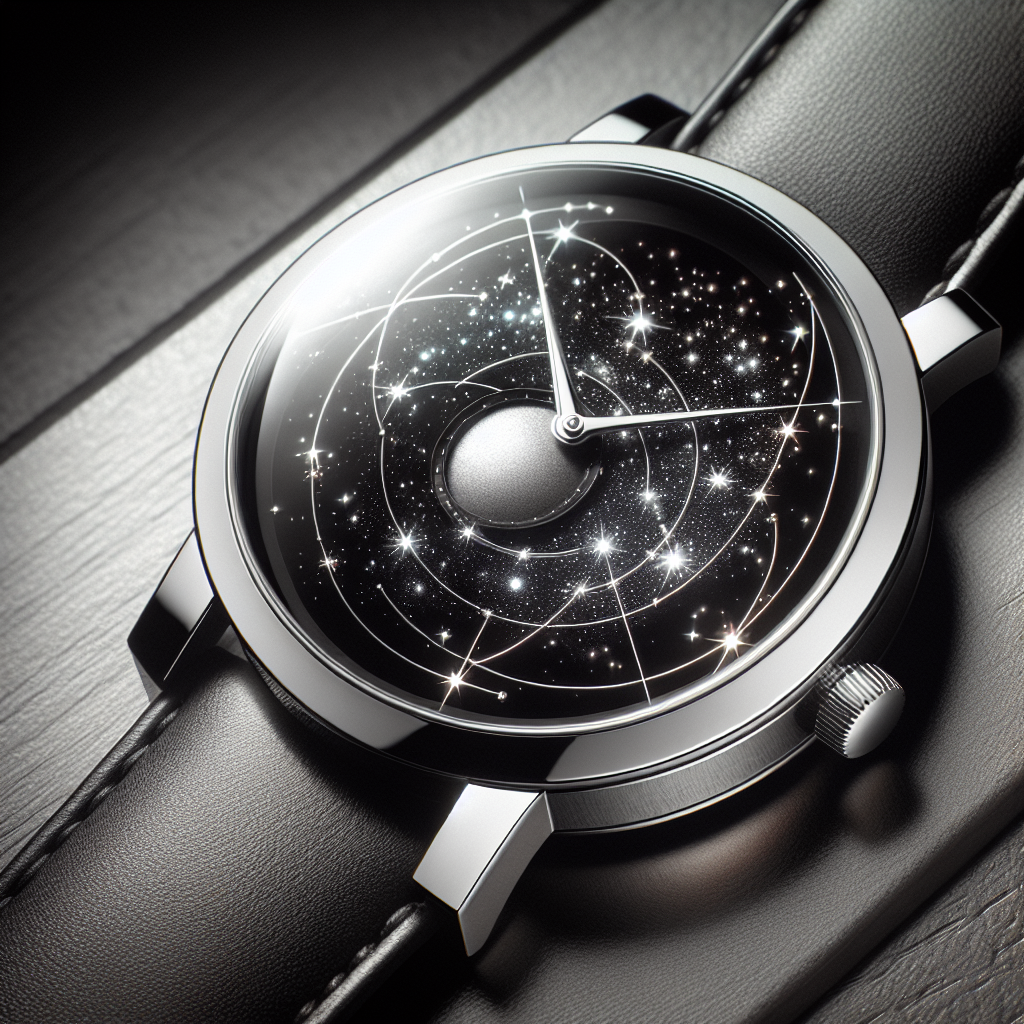

In [19]:
#pragma warning disable SKEXP0001

var prompt = @"
Think about an artificial object correlated to number {{$input}}.
Describe the image with one detailed sentence. The description cannot contain numbers.";

var executionSettings = new OpenAIPromptExecutionSettings 
{
    MaxTokens = 256,
    Temperature = 1
};

// Create a semantic function that generate a random image description.
var genImgDescription = kernel.CreateFunctionFromPrompt(prompt, executionSettings);

var random = new Random().Next(0, 200);
var imageDescriptionResult = await kernel.InvokeAsync(genImgDescription, new() { ["input"] = random });
var imageDescription = imageDescriptionResult.ToString();

// Use DALL-E 3 to generate an image. OpenAI in this case returns a URL (though you can ask to return a base64 image)
var imageUrl = await dallE.GenerateImageAsync(imageDescription.Trim(), 1024, 1024);

await SkiaUtils.ShowImage(imageUrl, 1024, 1024);

# Let's play a guessing game

Try to guess what the image is about, describing the content.

You'll get a score at the end 😉

In [20]:
// Prompt the user to guess what the image is
var guess = await InteractiveKernel.GetInputAsync("Describe the image in your words");

// Compare user guess with real description and calculate score
var origEmbedding = await textEmbedding.GenerateEmbeddingsAsync(new List<string> { imageDescription } );
var guessEmbedding = await textEmbedding.GenerateEmbeddingsAsync(new List<string> { guess } );
var similarity = TensorPrimitives.CosineSimilarity(origEmbedding.First().Span, guessEmbedding.First().Span);

Console.WriteLine($"Your description:\n{Utils.WordWrap(guess, 90)}\n");
Console.WriteLine($"Real description:\n{Utils.WordWrap(imageDescription.Trim(), 90)}\n");
Console.WriteLine($"Score: {similarity:0.00}\n\n");

Your description:
horloge


Real description:
An elegant and futuristic-looking wristwatch featuring a sleek black dial adorned with a
constellation of twinkling stars, encased in a gleaming silver frame and secured with a
supple leather strap.


Score: 0.83


